## Laboratoire 2
**Equipe 1** 



Membres: Kevin Chenier, Jeremie Bellegarde, Sebastien René


## Introduction

 Pour ce laboratoire, nous devons choisir 8 classes pour créer un ensemble d'images qui pourront être reconnu grâce aux notions que nous avons apprisent en classe.
 Pour ce faire, nous utiliserons Jupyter Notebook afin de séparer clairement chacune des étapes que nous deverons accomplir.
 Nous allons faire par nous même un réseau de neuronne et par la suite, utiliser des modeles déjà existant afin de comparer nos résultats. Ceci nous permettera de tirer une conclusion sur les forces et faiblesses de différents modèles.
 

## Importation des librairies nécéssaires

Les librairies qui nous seront nécéssaire pour le traitement des images sont les suivantes :


In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import imutils
import random
import os
import pickle
from tqdm.notebook import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.neural_network import MLPClassifier

## Augmentation des données

Voici le code utilisé pour l'augmentation des données. Ce code consiste à créer des nouvelles images à partir des images existantes en effectuant des opérations tel que, par exemple, la rotation. Le but de cette opération est d'avoir plus d'image pour notre echantillon.

In [2]:
def dataset_augmentation(path, nb_imgs):
    # Path to the image dataset
    p = Augmentor.Pipeline(str(path), output_directory=".")

    # Operations to be performed on the images:
    p.rotate90(probability=0.2)
    p.rotate270(probability=0.2)
    p.flip_left_right(probability=0.30)
    p.flip_top_bottom(probability=0.30)
    p.skew_tilt(probability=0.25, magnitude=0.1)
    p.random_distortion(probability=1, grid_width=2, grid_height=2, magnitude=4)

    # Specifyin the number of images to generate
    p.sample(nb_imgs)
    
    print({path}, ": augmentation done for", {nb_imgs}, "more images.")

## Choix du Dataset pour l'ensemble B

Voici notre choix d'images pour l'ensemble B. Cet ensemble est constitué de 8 symboles:

In [3]:
# Define the base data directory path
data_dir = Path.cwd() / "EnsembleB_H2020"

# A list of string with all the categories/labels in your database, i.e., each class subfolder name
CLASSES = [
    {
        "LABEL": "Cercle2", 
        "GROUP": 0,
        "PATH": os.path.join(data_dir, 'Cercles', 'Cercle2')
    },
    {
        "LABEL": "Cercle3", 
        "GROUP": 1,
        "PATH": os.path.join(data_dir, 'Cercles', 'Cercle3')
    },
    {
        "LABEL": "Diamant2",
        "GROUP": 2,
        "PATH": os.path.join(data_dir, 'Diamants', 'Diamant2')
    },
    {
        "LABEL":"Diamant3", 
        "GROUP": 3,
        "PATH": os.path.join(data_dir, 'Diamants', 'Diamant3')
    },
    {
        "LABEL":"Hexagone2", 
        "GROUP": 4,
        "PATH": os.path.join(data_dir, 'Hexagones', 'Hexagone2')
    },
    {
        "LABEL":"Hexagone3", 
        "GROUP": 5,
        "PATH": os.path.join(data_dir, 'Hexagones', 'Hexagone3')
    },
    {
        "LABEL":"Triangle2", 
        "GROUP": 6,
        "PATH": os.path.join(data_dir, 'Triangles', 'Triangle2')
    },
    {
        "LABEL":"Triangle3", 
        "GROUP": 7,
        "PATH": os.path.join(data_dir, 'Triangles', 'Triangle3')
    }
]

## Pretraitement des images

Nous avons commencé par redimmensionner les images, pour ensuite leur appliqué un filtre pour les rendre grises et pour les rendre flous. Les opérations qui nous ont permi d'avoir le plus d'amélioration selon nos test était l'application du filtre pour le flou et du filtre pour le gris. Nous en avous aussi profité pour redimensionner l'image tel que demandé dans l'ennoncé.

In [6]:
imageSize = (160, 160)

dataSet = []

# Read all the files and append to dataset
for CLASS in CLASSES:
    print(f"Reading files from class {CLASS['LABEL']}")
    for image in tqdm(glob(os.path.join(CLASS["PATH"], '*'))):
        # Read the image in grayscale
        gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        # Resize the image
        gray = cv2.resize(gray, imageSize)
        
        # Calculate contours
        blurred = cv2.GaussianBlur(gray, (5,5), 0)
        thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)[1]
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        polygons = []
        
        # Save the polygons
        for contour in contours:
            perimeter = cv2.arcLength(contour, True)
            approximation = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
            polygons.append(len(approximation))
        
        feature = [0 for i in range(16)]
        
        # Create the feature vector from polygons
        for polygon in polygons:
            feature[polygon] += 1
        
        # Create a data variable to add to dataSet
        data = {
            'image': gray,
            'label': CLASS['GROUP'],
            'polygons': polygons,
            'feature': feature
        }
        
        # Append data to dataSet
        dataSet.append(data)   

Reading files from class Cercle2


  0%|          | 0/184 [00:00<?, ?it/s]

Reading files from class Cercle3


  0%|          | 0/175 [00:00<?, ?it/s]

Reading files from class Diamant2


  0%|          | 0/130 [00:00<?, ?it/s]

Reading files from class Diamant3


  0%|          | 0/145 [00:00<?, ?it/s]

Reading files from class Hexagone2


  0%|          | 0/147 [00:00<?, ?it/s]

Reading files from class Hexagone3


  0%|          | 0/129 [00:00<?, ?it/s]

Reading files from class Triangle2


  0%|          | 0/164 [00:00<?, ?it/s]

Reading files from class Triangle3


  0%|          | 0/128 [00:00<?, ?it/s]

In [7]:
# Shuffle pictures
random.shuffle(dataSet)

# create X and y from DataSet
X = np.array([data['feature'] for data in dataSet])
y = np.array([data['label'] for data in dataSet])

# Creating files containing all the information about your model and saving them
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

## Machine learning training

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=84)

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

In [10]:
X_train = X_train.flatten()
X_test = X_test.flatten()
X_val = X_val.flatten()

In [11]:
X_train = X_train.reshape(len(y_train), len(X[0]))
X_test = X_test.reshape(len(y_test),len(X[0]))
X_val = X_val.reshape(len(y_val), len(X[0]))

## Réseau Neuronal

Voici notre modèle pour le Réseau Neuronal. Nous nous sommes basé sur la théorie vue en classe pour le faire. Une fois le modèle en place, nous avons essayer avec des hyperparamètres différents tel que le learning rate, le nombre de couches cachées ou un nombre d'itérations (epoch) plus ou moins élevé. Nous avons laissé comme données les hyperparamètre pour lesquels nous semblions avoir le plus de succès. 

    Nos hyperparamètre finaux sont les suivants:   epoch = 3000
                                                   couche caché = 50
                                                   learning rate = 0.01
                                                


In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    o = sigmoid(z)
    return o*(1-o)

In [13]:
class NeuralNetwork:

    def __init__(self, classes, features, hidden_units=15, epochs=300,
                 learning_rate=0.01, batches=1):
        self.classes = classes
        self.features = features
        self.hidden_units = hidden_units
        self.batches = batches
        self.w1, self.w2 = self.weights()
        self.learning_rate = learning_rate
        self.epochs = epochs
        
    def error(self, y, output):
        error = -np.sum(y*np.log(output))
        return 0.5 * np.mean(error)

    def weights(self):
        w1 = np.random.rand(self.hidden_units, self.features)
        w2 = np.random.rand(self.classes, self.hidden_units)
        return w1, w2

    def forward_step(self, X):
        z1 = np.dot(self.w1,X.T)
        hidden_output = sigmoid(z1)
        z2 = np.dot(self.w2,hidden_output)
        final_output = sigmoid(z2)
        return z1, hidden_output, z2, final_output

    def backward_step(self, X, z1, hidden_output, final_output, y):
        output_error = final_output - y
        output_delta = self.w2.T.dot(output_error) * sigmoid_prime(z1)
        grad1 = output_delta.dot(X)
        grad2 = output_error.dot(hidden_output.T)
        return grad1, grad2

    def backprop_step(self, X, y):
        z1, hidden_output, z2, final_output = self.forward_step(X)
        y = y.T
        grad1, grad2 = self.backward_step(X, z1, hidden_output, final_output, y)
        error = self.error(y, final_output)
        return error, grad1, grad2

    def fit(self, X, y):
        self.error_ = []
        lb = preprocessing.LabelBinarizer()
        y = lb.fit_transform(y)

        X_batches = np.array_split(X, self.batches)
        y_batches = np.array_split(y, self.batches)

        for i in range(self.epochs):
            epoch_errors = []
            for Xi, yi in zip(X_batches, y_batches):
                error, grad1, grad2 = self.backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
            print(i, np.mean(epoch_errors))
        return self

    def predict(self, X):
        z1, hidden_output, z2, final_output = self.forward_step(X)
        return np.argmax(z2.T, 1)

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

In [14]:
nn = NeuralNetwork(
    classes=8, 
    batches=30,
    hidden_units=50,
    features=len(X[0]),
    learning_rate=0.01,
    epochs=3000,
).fit(X_train, y_train);

0 22.871065822516698
1 26.519932459063593
2 26.369826453232143
3 26.213955998204494
4 26.05035932139638
5 25.87737307457933
6 25.693684675281556
7 25.498406099569554
8 25.291160167743524
9 25.072165805663975
10 24.842304196316384
11 24.603144929967076
12 24.356912465926207
13 24.106380295101378
14 23.8546933565935
15 23.605136016099387
16 23.360878127924412
17 23.124739457257945
18 22.899009344020538
19 22.685344802836592
20 22.484751491830313
21 22.297634946937333
22 22.123899137249712
23 21.963067075647864
24 21.81440209612022
25 21.677015321983465
26 21.549951972779034
27 21.432254808265117
28 21.323006637722674
29 21.221355624549695
30 21.126527598040482
31 21.03782927948156
32 20.95464565808946
33 20.87643398835699
34 20.802716174564456
35 20.733070724846907
36 20.66712500940674
37 20.604548232730433
38 20.545045305829934
39 20.488351658298576
40 20.434228940797848
41 20.38246151984055
42 20.33285364559338
43 20.285227170314137
44 20.239419702970984
45 20.195283099567163
46 20.152

395 15.996631061463194
396 15.989438373480555
397 15.982259640432611
398 15.975095007419558
399 15.967944616472941
400 15.960808606523255
401 15.953687113370323
402 15.94658026965634
403 15.939488204841568
404 15.932411045182683
405 15.925348913713636
406 15.918301930229067
407 15.911270211270145
408 15.904253870112878
409 15.89725301675875
410 15.890267757927681
411 15.88329819705325
412 15.876344434280128
413 15.869406566463613
414 15.862484687171355
415 15.855578886687002
416 15.848689252015932
417 15.8418158668928
418 15.83495881179104
419 15.828118163934128
420 15.821293997308588
421 15.814486382678716
422 15.807695387602894
423 15.800921076451518
424 15.794163510426412
425 15.787422747581696
426 15.780698842846101
427 15.773991848046546
428 15.76730181193307
429 15.760628780204968
430 15.753972795538102
431 15.747333897613338
432 15.740712123146023
433 15.734107505916523
434 15.727520076801673
435 15.720949863807169
436 15.71439689210079
437 15.707861184046449
438 15.701342759238

790 14.08589360058981
791 14.082219120513468
792 14.078546994461421
793 14.074877218344097
794 14.071209788175224
795 14.067544700070357
796 14.063881950245333
797 14.060221535014817
798 14.056563450790774
799 14.052907694081005
800 14.049254261487645
801 14.045603149705702
802 14.041954355521577
803 14.038307875811595
804 14.03466370754053
805 14.031021847760174
806 14.027382293607838
807 14.023745042304942
808 14.020110091155543
809 14.016477437544903
810 14.012847078938044
811 14.009219012878308
812 14.005593236985947
813 14.001969748956673
814 13.998348546560264
815 13.994729627639106
816 13.991112990106831
817 13.987498631946867
818 13.983886551211063
819 13.980276746018271
820 13.976669214552969
821 13.973063955063877
822 13.969460965862538
823 13.965860245322004
824 13.962261791875413
825 13.958665604014652
826 13.955071680288993
827 13.951480019303746
828 13.94789061971891
829 13.94430348024785
830 13.940718599655963
831 13.937135976759341
832 13.933555610423502
833 13.92997749

1187 12.804524177951139
1188 12.80173094994113
1189 12.79893955582607
1190 12.796149989853042
1191 12.793362246264358
1192 12.790576319298392
1193 12.78779220319048
1194 12.785009892173782
1195 12.782229380480151
1196 12.779450662341022
1197 12.776673731988284
1198 12.773898583655136
1199 12.771125211576994
1200 12.76835360999235
1201 12.765583773143641
1202 12.762815695278125
1203 12.760049370648762
1204 12.757284793515087
1205 12.75452195814407
1206 12.751760858810975
1207 12.749001489800246
1208 12.746243845406362
1209 12.743487919934681
1210 12.740733707702312
1211 12.737981203038986
1212 12.735230400287856
1213 12.732481293806396
1214 12.729733877967197
1215 12.72698814715885
1216 12.724244095786727
1217 12.721501718273858
1218 12.718761009061705
1219 12.716021962611023
1220 12.71328457340264
1221 12.710548835938262
1222 12.707814744741297
1223 12.705082294357608
1224 12.70235147935633
1225 12.69962229433062
1226 12.696894733898445
1227 12.694168792703326
1228 12.691444465415115
1

1585 11.802989505811674
1586 11.800708979506105
1587 11.798429472872982
1588 11.796150985146324
1589 11.793873515576136
1590 11.791597063428462
1591 11.78932162798549
1592 11.787047208545527
1593 11.784773804423121
1594 11.782501414949072
1595 11.78023003947048
1596 11.77795967735081
1597 11.77569032796988
1598 11.773421990723945
1599 11.771154665025703
1600 11.768888350304328
1601 11.766623046005494
1602 11.764358751591386
1603 11.762095466540739
1604 11.759833190348845
1605 11.757571922527543
1606 11.75531166260527
1607 11.753052410127014
1608 11.750794164654376
1609 11.74853692576551
1610 11.746280693055171
1611 11.744025466134666
1612 11.741771244631868
1613 11.739518028191217
1614 11.737265816473654
1615 11.735014609156655
1616 11.732764405934196
1617 11.730515206516698
1618 11.728267010631054
1619 11.726019818020545
1620 11.723773628444848
1621 11.721528441679975
1622 11.719284257518249
1623 11.71704107576828
1624 11.714798896254871
1625 11.712557718819017
1626 11.71031754331785


1981 10.982863046147168
1982 10.981017826168891
1983 10.979173758427446
1984 10.977330842086872
1985 10.975489076300343
1986 10.973648460210223
1987 10.97180899294803
1988 10.969970673634512
1989 10.96813350137964
1990 10.966297475282635
1991 10.964462594431984
1992 10.962628857905479
1993 10.960796264770213
1994 10.958964814082629
1995 10.95713450488852
1996 10.955305336223073
1997 10.95347730711088
1998 10.951650416565942
1999 10.94982466359175
2000 10.948000047181232
2001 10.94617656631684
2002 10.94435421997055
2003 10.942533007103886
2004 10.940712926667935
2005 10.938893977603389
2006 10.937076158840558
2007 10.935259469299412
2008 10.933443907889576
2009 10.931629473510384
2010 10.92981616505089
2011 10.92800398138989
2012 10.926192921395973
2013 10.924382983927499
2014 10.922574167832675
2015 10.920766471949559
2016 10.91895989510607
2017 10.917154436120034
2018 10.915350093799226
2019 10.913546866941354
2020 10.911744754334126
2021 10.909943754755234
2022 10.908143866972438
20

2374 10.329170095338407
2375 10.327626243981506
2376 10.326082602355552
2377 10.324539167151837
2378 10.322995935062774
2379 10.321452902781987
2380 10.319910067004335
2381 10.318367424426034
2382 10.316824971744657
2383 10.315282705659262
2384 10.3137406228704
2385 10.31219872008023
2386 10.31065699399254
2387 10.309115441312839
2388 10.307574058748413
2389 10.306032843008394
2390 10.304491790803818
2391 10.302950898847694
2392 10.301410163855055
2393 10.299869582543046
2394 10.298329151630977
2395 10.296788867840366
2396 10.295248727895036
2397 10.293708728521175
2398 10.292168866447364
2399 10.29062913840468
2400 10.289089541126742
2401 10.287550071349775
2402 10.286010725812677
2403 10.284471501257084
2404 10.282932394427423
2405 10.281393402070979
2406 10.279854520937954
2407 10.278315747781553
2408 10.276777079358016
2409 10.275238512426684
2410 10.273700043750077
2411 10.272161670093945
2412 10.270623388227339
2413 10.269085194922654
2414 10.267547086955698
2415 10.2660090611057

2752 9.735276186106022
2753 9.733627989355869
2754 9.731979242704007
2755 9.730329946174114
2756 9.72868009980537
2757 9.727029703652587
2758 9.725378757786176
2759 9.723727262292293
2760 9.72207521727287
2761 9.720422622845682
2762 9.718769479144406
2763 9.717115786318706
2764 9.71546154453428
2765 9.713806753972927
2766 9.712151414832606
2767 9.710495527327522
2768 9.70883909168817
2769 9.707182108161398
2770 9.705524577010486
2771 9.703866498515207
2772 9.70220787297187
2773 9.700548700693412
2774 9.698888982009453
2775 9.697228717266333
2776 9.695567906827222
2777 9.693906551072148
2778 9.692244650398068
2779 9.69058220521894
2780 9.688919215965777
2781 9.68725568308671
2782 9.68559160704704
2783 9.68392698832934
2784 9.68226182743345
2785 9.6805961248766
2786 9.678929881193444
2787 9.677263096936116
2788 9.675595772674296
2789 9.673927908995289
2790 9.672259506504039
2791 9.670590565823245
2792 9.668921087593377
2793 9.66725107247275
2794 9.665580521137592
2795 9.663909434282084
2

In [15]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))

Train Accuracy: 80.21%


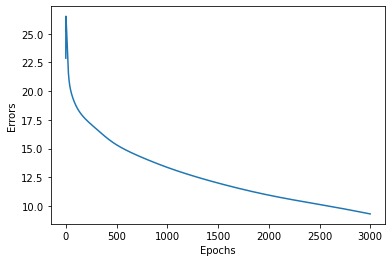

In [16]:
def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.xlabel('Epochs')
    plt.ylabel('Errors')
    plt.show()
    
plot_error(nn)

In [17]:
y_train_prediction = nn.predict(X_train)
y_test_prediction = nn.predict(X_test)
y_prediction = nn.predict(X_val)

### Matrice de confusion ensemble "train"

In [18]:
print(confusion_matrix(y_train,y_train_prediction))
print(classification_report(y_train,y_train_prediction))

[[114   6   0   0   1   6   1   0]
 [  2 104   0   1   2   3   0   0]
 [  6   0  58   4   6   4   2   2]
 [  9   2   4  58   4   9   2   2]
 [ 12   0   1   1  76   9   0   0]
 [  1   1   0   0   0  78   0   0]
 [  1   0  11   3   3   0  85   0]
 [  1   0   5  14   2   4   5  43]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       128
           1       0.92      0.93      0.92       112
           2       0.73      0.71      0.72        82
           3       0.72      0.64      0.68        90
           4       0.81      0.77      0.79        99
           5       0.69      0.97      0.81        80
           6       0.89      0.83      0.86       103
           7       0.91      0.58      0.71        74

    accuracy                           0.80       768
   macro avg       0.81      0.79      0.79       768
weighted avg       0.81      0.80      0.80       768



### Matrice de confusion ensemble "test"

In [19]:
print(confusion_matrix(y_test,y_test_prediction))
print(classification_report(y_test,y_test_prediction))

[[10 21  0  0  1  2  0  0]
 [ 0 26  1  0  2  2  1  0]
 [ 0  3 12  1  3  2  1  2]
 [ 1  4  1 15  0  4  4  1]
 [ 1  3  0  3 11  9  2  0]
 [ 0  5  0  0  3 20  1  0]
 [ 2  2  6  2  2  0 20  5]
 [ 0  1  0  3  3  2  4 11]]
              precision    recall  f1-score   support

           0       0.71      0.29      0.42        34
           1       0.40      0.81      0.54        32
           2       0.60      0.50      0.55        24
           3       0.62      0.50      0.56        30
           4       0.44      0.38      0.41        29
           5       0.49      0.69      0.57        29
           6       0.61      0.51      0.56        39
           7       0.58      0.46      0.51        24

    accuracy                           0.52       241
   macro avg       0.56      0.52      0.51       241
weighted avg       0.56      0.52      0.51       241



### Matrice de confusion ensemble "Val"

In [20]:
print(confusion_matrix(y_val,y_prediction))
print(classification_report(y_val,y_prediction))

[[ 3 18  0  1  0  0  0  0]
 [ 2 21  2  2  0  1  3  0]
 [ 7  6  4  2  3  0  0  2]
 [ 1  7  3  3  1  3  2  5]
 [ 0  1  1  1  7  9  0  0]
 [ 1  9  0  1  1  8  0  0]
 [ 6  1  1  1  0  0  4  9]
 [ 5  2  5  3  0  5  6  4]]
              precision    recall  f1-score   support

           0       0.12      0.14      0.13        22
           1       0.32      0.68      0.44        31
           2       0.25      0.17      0.20        24
           3       0.21      0.12      0.15        25
           4       0.58      0.37      0.45        19
           5       0.31      0.40      0.35        20
           6       0.27      0.18      0.22        22
           7       0.20      0.13      0.16        30

    accuracy                           0.28       193
   macro avg       0.28      0.27      0.26       193
weighted avg       0.28      0.28      0.26       193



## Support Vector Machine (SVM lineair)

In [21]:
svc = SVC(cache_size=1500)
parameter = {'kernel': ['linear'], 'C': [0.001, 0.1, 1, 10], 'class_weight': ['balanced'], 'gamma': ['scale']}
classifier = GridSearchCV(svc, param_grid = parameter, cv = 10, n_jobs = 5, scoring = 'accuracy', verbose=4)
classifier.fit(X_train, y_train)
print("LINEAR : The best hyperparameters are %s with a score of %0.2f" % (classifier.best_params_, classifier.best_score_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


LINEAR : The best hyperparameters are {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'} with a score of 0.60


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    1.2s finished


Nous avons constaté qu'augmenter la grosseur de la cache ne changeait pas nos résultats, alors nous l'avons gardé à 1500.

In [22]:
SVMaccuracy = pd.DataFrame(classifier.cv_results_['mean_test_score'], index = [x['C'] for x  in classifier.cv_results_['params']], columns = ['SVM accuracy'])
print(SVMaccuracy)

        SVM accuracy
0.001       0.117191
0.100       0.325461
1.000       0.533903
10.000      0.596377


## K-Nearest Neighbor (KNN)

In [23]:
# K-Nearest Neighbor 
def KNN_model (X_train, X_test, y_train, y_test, weights):
    
    KNN_accuracy_uniform = []
    KNN_f1_uniform = []
    
    KNNParams = [3,5,10]

    for neighbors in KNNParams:

        model = KNeighborsClassifier(n_neighbors = neighbors, weights = weights)
        KNNmodel = model.fit(X_train, y_train)
        y_prediction = KNNmodel.predict(X_test)
        
        # Calculate the accuracy of KNN
        accuracy = accuracy_score(y_test, y_prediction)
        f1score = f1_score(y_test, y_prediction, average = 'weighted') 

        KNN_accuracy_uniform.append(accuracy)
        KNN_f1_uniform.append(f1score)
        
        # Print the F1 score
        print("F1 score : KNN")
        print(f1_score(y_test, y_prediction, average = 'weighted'))
        
        # Print the accuracy score
        print("Accuracy score : KNN avec k = " + str(neighbors) + " et poid = " + weights)
        print(KNNmodel.score(X_test, y_test))
        
        clf  = KNeighborsClassifier(n_neighbors = neighbors, weights = 'distance')
        
        ## KNN - Cross-validation
        print("Cross-validation")
        KNN_scores = cross_val_score(clf , X, y, cv = 10)
        print(sum(KNN_scores) / 10)
        print('\n')

In [24]:
KNN_model(X_train, X_test, y_train, y_test, 'uniform')
KNN_model(X_train, X_test, y_train, y_test, 'distance')

F1 score : KNN
0.44563805114797256
Accuracy score : KNN avec k = 3 et poid = uniform
0.45228215767634855
Cross-validation
0.6488360881542701


F1 score : KNN
0.4768436068686119
Accuracy score : KNN avec k = 5 et poid = uniform
0.48132780082987553
Cross-validation
0.6555096418732782


F1 score : KNN
0.5319203163343927
Accuracy score : KNN avec k = 10 et poid = uniform
0.5394190871369294
Cross-validation
0.6679820936639118


F1 score : KNN
0.483941339888567
Accuracy score : KNN avec k = 3 et poid = distance
0.4896265560165975
Cross-validation
0.6488360881542701


F1 score : KNN
0.49115532261606787
Accuracy score : KNN avec k = 5 et poid = distance
0.4979253112033195
Cross-validation
0.6555096418732782


F1 score : KNN
0.4820374093014463
Accuracy score : KNN avec k = 10 et poid = distance
0.4854771784232365
Cross-validation
0.6679820936639118




## Réseaux de neurones (RN)

In [25]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X, y)

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [26]:
y_test_prediction = mlp.predict(X_test)
y_train_prediction = mlp.predict(X_train)
y_prediction = mlp.predict(X_val)

### Matrice de confusion ensemble "train"

In [27]:
print(confusion_matrix(y_train,y_train_prediction))
print(classification_report(y_train,y_train_prediction))

[[ 18   0   0   7 102   0   1   0]
 [ 21   0   0   5  84   0   2   0]
 [ 11   0   0   4  65   0   2   0]
 [ 22   0   0   5  62   0   1   0]
 [  7   0   0   2  90   0   0   0]
 [ 10   0   0   1  69   0   0   0]
 [ 15   0   0  33  49   0   6   0]
 [  4   0   0  15  48   0   7   0]]
              precision    recall  f1-score   support

           0       0.17      0.14      0.15       128
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00        82
           3       0.07      0.06      0.06        90
           4       0.16      0.91      0.27        99
           5       0.00      0.00      0.00        80
           6       0.32      0.06      0.10       103
           7       0.00      0.00      0.00        74

    accuracy                           0.15       768
   macro avg       0.09      0.15      0.07       768
weighted avg       0.10      0.15      0.08       768



c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Matrice de confusion ensemble "test"

In [28]:
print(confusion_matrix(y_test,y_test_prediction))
print(classification_report(y_test,y_test_prediction))

[[ 7  1  0  4 21  0  1  0]
 [ 6  0  0  2 21  0  3  0]
 [ 2  0  0  0 21  0  1  0]
 [ 3  0  0  4 22  0  1  0]
 [ 4  0  0  0 25  0  0  0]
 [ 5  0  0  1 23  0  0  0]
 [ 3  0  1  9  7  0 19  0]
 [ 3  0  0  4  9  0  8  0]]
              precision    recall  f1-score   support

           0       0.21      0.21      0.21        34
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        24
           3       0.17      0.13      0.15        30
           4       0.17      0.86      0.28        29
           5       0.00      0.00      0.00        29
           6       0.58      0.49      0.53        39
           7       0.00      0.00      0.00        24

    accuracy                           0.23       241
   macro avg       0.14      0.21      0.15       241
weighted avg       0.16      0.23      0.17       241



## Analyse des résultats 

Avec les tests sur nos modèles, nous avons pu constater que certains modèles avaient de meilleurs résultats que d'autre. Nous avons essayé d'optimiser les résultats avec les hyperparamètre mais, de nos expériences, nous avons trouvé que notre réseau de neurone était le plus efficace.


## Conclusion et intreprétation des résultats

Pour conclure, nous avons réussi à faire un modèle d'apprentissage machine en fonction des notions vue en cours. Nous avons remarqué que , dépendament du models, les hyperparamètres peuvent  varié et avoir des effets differents. Cela nous démontre l'importance de choisir un bon modèle en fonction dude la situation qu'on veut résoudre, car un mauvais choix de modèle peut s'avérer catastrophique. Ce laboratoire nous a permis d'appliquer nos nouvelles connaissances vue en classe et de les approfondirs. Il nous a aussi permi d'apprendre l'importance d'un bon choix pour les modèles sélectionner en fonction de la situation et l'importance d'une bonne décision face aux hyperparamètres.